# <p style="background-color:#063d91;color:white;font-size:90%;text-align:center;border-radius:5px 5px;height:40px;padding-top: 5px;"> ⚙️Bearing Fault Diagnosis using Acoustic Emissions</p>

This notebook showcases a simple bearing failure detection using a convolutional 
neural network.'

In [266]:
# imports
from scipy.io import loadmat
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import layers, Model

import matplotlib.pyplot as plt

from IntegratedGradients.integrated_gradients import IntegratedGradients

### About the data

The dataset contains vibration signals collected from bearings under time-varying  
rotational speed conditions from the University of Ottawa. It consists in 4 audios  
of 12 seconds each of the different engines.

The recording sampling rate is 10 kHz.


The dataset is publicly available on kaggle.  

In [267]:
FS = 10000

## load data
data = loadmat('data\dataset.mat\dataset.mat')

## extract different failure types
normal = np.squeeze(data['normal'])
inner = np.squeeze(data['inner'])
outer = np.squeeze(data['outer'])
roller = np.squeeze(data['roller'])

### Visualize data

To get an idea of the data we will plot an instance for each of the fault classes.

In [268]:
def visualize_data(
    data: tuple,
    fault_types: tuple,
    n_values: int
) -> None:

    
    # generate x axis
    x_time = np.arange(0, n_values * 1/FS, 1/FS)
    
    plt.figure(figsize=(6,3))
    
    for idx, element in enumerate(data):
        plt.plot(x_time, element[:n_values], label=fault_types[idx])
    
    plt.ylabel('Accelaration m/s²')
    plt.xlabel('Time [s]')
    plt.title('Different fault types in comparison')
    plt.grid()
    plt.legend()
    
    plt.show()

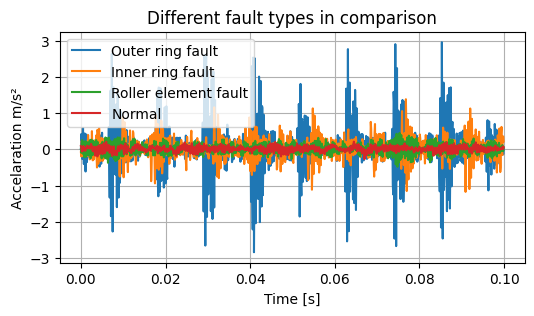

In [269]:
visualize_data(
    (outer, inner, roller, normal),
    ('Outer ring fault', 'Inner ring fault', 'Roller element fault', 'Normal'),
    1000
)

From the plotted signals above it is clear, that the present diagnosis task is not  
of high difficulty, since the different failures are clearly distinguishable in  
the plot.  
Nevertheless different diagnosis methods are demonstrated within this project.  
It is expected to result in really accurate failure diagnosis.


### Prepare data

In other to a classify the health condition of a bearing, we import the data and  
create instances from them. The idea is to separate the signal of a condition into  
batches of data that will be processed and have their feature extracted.  
In this nb no overlap is used since the problem appears to be relatively modest  
to solve. 

In [270]:
def window_data(
    data: np.ndarray,
    instances: int,
) -> np.ndarray:

    try: 
        windowed = np.split(data, instances)
    
    except:
        print('Please choose an appropriate number of instances. \n \
            (Has to be an exact divider of 120000) ') 
    
    return np.array(windowed)

In [271]:
# window data in n instances to have more effective samples available
# generate also the respective labels hereby
n_instances = 60

data = []
labels= []

for idx, element in enumerate([normal, inner, outer, roller]):
    
    windowed = window_data(
        element, 
        n_instances
    )
    
    data.append(windowed)
    
    category = np.ones((windowed.shape[0], )) * idx
    
    labels.append(category)
        
data = np.vstack(data)
labels = np.hstack((labels))

**Visualize windowed data**

Below is a future training instance for each failure class plotted.

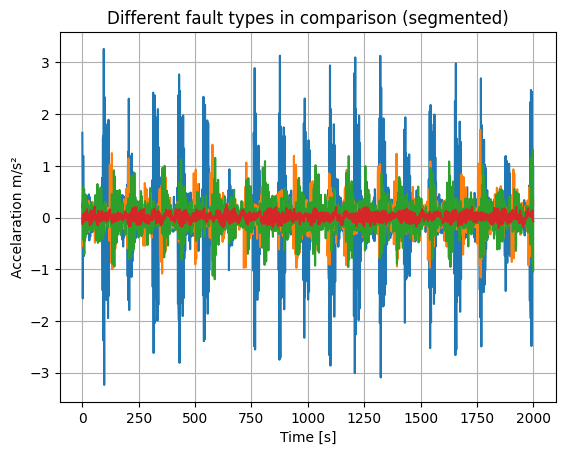

In [272]:
for i in range(4, 0, -1):
    plt.plot(data[35 * i])

plt.ylabel('Accelaration m/s²')
plt.xlabel('Time [s]')
plt.title('Different fault types in comparison (segmented)')
plt.grid()
plt.show()

**Split data in train and test set**

Now a training and testing set is created. The training set will be used to  
optimize the model, whereas the testing set will be used to test the models  
generalization ability on unseen data.

In [273]:
x_train, x_test, y_train, y_test = train_test_split(
    data,
    labels,
    test_size=0.2
)

x_train = np.expand_dims(x_train, (-1))
x_test = np.expand_dims(x_test, (-1))

**Scale data**

Deep learning algorithms, owing to their intricate architectures and complex  
optimization processes, often exhibit improved performance when the training data  
is appropriately scaled within a specific interval. Scaling the data helps in  
standardizing the input features, ensuring that they are within a comparable range.  
This normalization process aids in mitigating issues such as vanishing or exploding  
gradients during training, which can hinder the convergence of the model. Moreover,  
scaling enhances the effectiveness of optimization algorithms by enabling them to  
navigate the parameter space more efficiently. By bringing the data within a  
consistent range, scaling facilitates the learning process, leading to more stable  
and reliable model performance

In this NB the data is scaled to the range [0, 1].

In [274]:
x_train = (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train))
x_test = (x_test - np.min(x_test)) / (np.max(x_test) - np.min(x_test))

### Neural network classification of the different faults

In [290]:
def build_model(
    window_length: int,
    n_features: int,
    n_classes: int=4
) -> Model:
    
    input_data = layers.Input(shape=(window_length, n_features))
    
    x = layers.Conv1D(filters=8, kernel_size=16, padding='same')(input_data)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(pool_size=3)(x)
    
    x = layers.Conv1D(filters=8, kernel_size=7, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(pool_size=3)(x)
    
    x = layers.Conv1D(filters=16, kernel_size=5, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(pool_size=3)(x)
    
    x = layers.Conv1D(filters=16, kernel_size=3, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(pool_size=3)(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(units=100, activation='relu')(x)
    x = layers.Dropout(rate=0.5)(x)
    
    
    
    out = layers.Dense(units=n_classes, activation='softmax')(x)
    
    
    model = Model(
        inputs=[input_data],
        outputs=[out]
    )
    
    opt = tf.optimizers.Adam(
        lr=0.0002, 
        beta_1=0.9
    )
    
    model.compile(
        loss=['sparse_categorical_crossentropy'],
        optimizer=opt,
        metrics=['sparse_categorical_accuracy']
    )
    
    return model

In [291]:
model = build_model(
    x_train.shape[1],
    x_train.shape[2],
)

Since the amount of available data-samples is very sparse, a low batch size is  
chosen

In [294]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=15,
    batch_size=2
)

Epoch 1/15
96/96 [==============================] - 1s 12ms/step - loss: 0.2599 - sparse_categorical_accuracy: 0.9219 - val_loss: 0.4404 - val_sparse_categorical_accuracy: 0.7708
Epoch 2/15
96/96 [==============================] - 1s 12ms/step - loss: 0.2158 - sparse_categorical_accuracy: 0.9219 - val_loss: 0.1749 - val_sparse_categorical_accuracy: 0.9583
Epoch 3/15
96/96 [==============================] - 1s 11ms/step - loss: 0.1692 - sparse_categorical_accuracy: 0.9375 - val_loss: 0.4205 - val_sparse_categorical_accuracy: 0.7708
Epoch 4/15
96/96 [==============================] - 1s 12ms/step - loss: 0.1548 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.1784 - val_sparse_categorical_accuracy: 0.9375
Epoch 5/15
96/96 [==============================] - 1s 12ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.0727 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/15
96/96 [==============================] - 1s 11ms/step - loss: 0.1376 - sparse_categorical_accu

Below we can see that our failure-detection model can achieve a very high accuracy  
on the train data as well as the validation data.

Achieving **high accuracy on the training dataset** suggests that the model has  
effectively learned the patterns and features present in the training data, capturing  
the underlying relationships between inputs and outputs. This demonstrates the  
model's capacity to generalize well to unseen data instances, a crucial characteristic  
for its practical applicability.

Similarly, obtaining a **high accuracy on the validation dataset** corroborates  
the model's ability to perform effectively on data it hasn't been directly trained  
on. This indicates that the model has not overfit to the training data, wherein it  
would merely memorize the training examples without truly learning the underlying  
patterns. Instead, it has learned to generalize from the training data, making accurate  
predictions on new, unseen data.

The consistency in high accuracy across both the training and validation datasets  
provides confidence in the model's reliability and its potential utility in  
real-world applications. However, it's important to continuously monitor the model's  
performance and possibly refine it further to ensure its continued effectiveness as  
new data becomes available or as the problem domain evolves.

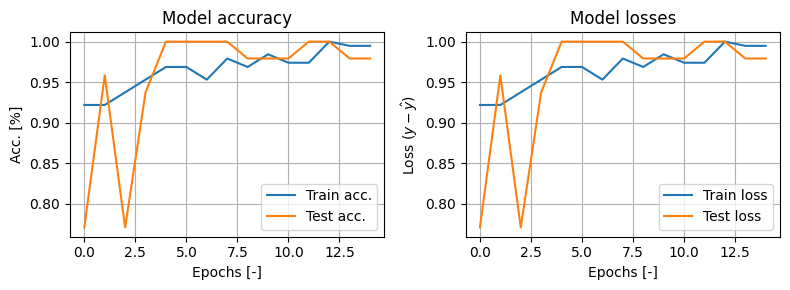

In [295]:
## plot history

fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].plot(history.history['sparse_categorical_accuracy'], label='Train acc.')
axs[0].plot(history.history['val_sparse_categorical_accuracy'], label='Test acc.')
axs[0].set_ylabel('Acc. [%]')
axs[0].set_xlabel('Epochs [-]')
axs[0].set_title('Model accuracy')
axs[0].legend()
axs[0].grid()

axs[1].plot(history.history['sparse_categorical_accuracy'], label='Train loss')
axs[1].plot(history.history['val_sparse_categorical_accuracy'], label='Test loss')
axs[1].set_ylabel('Loss $(y-\hat{y})$')
axs[1].set_xlabel('Epochs [-]')
axs[1].set_title('Model losses')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

### Visualize decision in "live" system when using trained model

Now we will take a look at the decision boundaries of the trained and untrained  
model. We will do so in projecting the datasamples on a 2D plane. Hereby one  
datapoint represents a windowed-datainstance.

In the **left** plot, we visualize the decision landscape of the **untrained** model,  
revealing its incapacity to effectively separate fault classes. The lack of  
distinct boundaries indicates the model's inability to discern between different  
classes, highlighting its initial state of inadequate classification capability.

On the **right**, the decision landscape of the **trained** model is depicted,  
showcasing its ability to discern fault classes through learned features in the  
time-series signals. The distinct boundaries observed indicate the model's capacity  
to accurately separate different fault classes, reflecting its enhanced capability  
for precise failure detection. This successful classification underscores the  
effectiveness of the model's training process in capturing and utilizing relevant  
features for accurate fault identification.

In [136]:
def order_indices(
    y_train,
    labels=[0, 1, 2, 3]
):
    
    class_indices = []
    
    for label in labels:
        class_indices.append(np.where(y_train == label))
    
    return class_indices

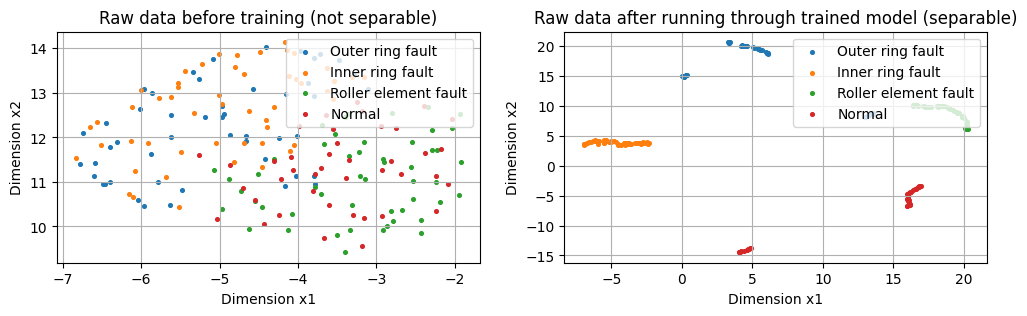

In [137]:
## visualize feature space
import umap


fig, axs = plt.subplots(1, 2, figsize=(12,3))

classes = order_indices(y_train)
labels = ('Outer ring fault', 'Inner ring fault', 'Roller element fault', 'Normal')


features = umap.UMAP(
    n_neighbors=10
).fit(np.squeeze(x_train))

for i in range(len(classes)):
    axs[0].scatter(features.embedding_[classes[i]][:, 0], features.embedding_[classes[i]][:, 1], s=7, label=labels[i])
axs[0].set_xlabel('Dimension x1')
axs[0].set_ylabel('Dimension x2')
axs[0].set_title('Raw data before training (not separable)')
axs[0].legend(loc='upper right')
axs[0].grid()


features = umap.UMAP(
    n_neighbors=10
).fit(np.squeeze(model(x_train)))

for i in range(len(classes)):
    axs[1].scatter(features.embedding_[classes[i]][:, 0], features.embedding_[classes[i]][:, 1], s=7, label=labels[i])
axs[1].set_xlabel('Dimension x1')
axs[1].set_ylabel('Dimension x2')
axs[1].set_title('Raw data after running through trained model (separable)')
axs[1].legend(loc='upper right')
axs[1].grid()

plt.show()


### Visualize important regions in the signals

***(NOTE: The here discussed algorithm will be explained in-depth in another notebook)***

Now that we have successfully trained a fault-distinguishing model with a remarkable  
accuracy level (approximately 100%), it becomes intriguing to delve into an analysis  
of the model's decision-making process when deployed in a real-time system.

To facilitate this examination, we will simulate a real-time inference scenario.  
In this simulation, a genuine data instance will be inputted into the trained model  
to predict the failure class, exemplified by an outer ring fault in this instance.  
Subsequently, we will compute the gradients of this prediction along an interpolated  
path of the real data instance and integrate the resulting outcome.

The ensuing visualization will provide insight into the model's behavior.

timeseries SHAPE: (None, 2000)


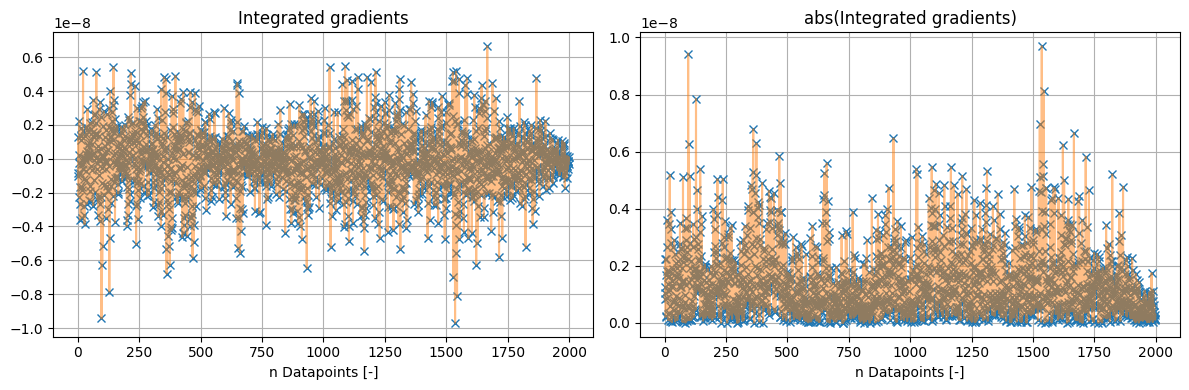

In [139]:
baseline = tf.zeros(2000)
x_ig = np.squeeze(x_test[4]).astype('float32')

ig = IntegratedGradients(model)

value = ig.integrated_gradients(
    baseline,
    x_ig
)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(value, 'x')
plt.plot(value, alpha=0.5)
plt.xlabel('n Datapoints [-]')
plt.title('Integrated gradients')
plt.grid()
plt.tight_layout()

value = abs(value)

plt.subplot(122)
plt.plot(value, 'x')
plt.plot(value, alpha=0.5)
plt.xlabel('n Datapoints [-]')
plt.title('abs(Integrated gradients)')
plt.grid()
plt.tight_layout()
plt.show()

In the provided plot, significant signal segments pivotal for the decision-making  
mechanism of the trained fault-detection model are emphasized. Particularly  
noteworthy are signal regions exhibiting a conspicuous impulse response, largely  
attributed to the overrun of bearing balls within the defective region. These  
distinctive signal characteristics serve as the principal factors shaping the  
model's decision-making process, highlighting their critical role in facilitating  
accurate fault detection.

<ipython-input-260-ee0d481c3084>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(211)


<Figure size 640x480 with 0 Axes>

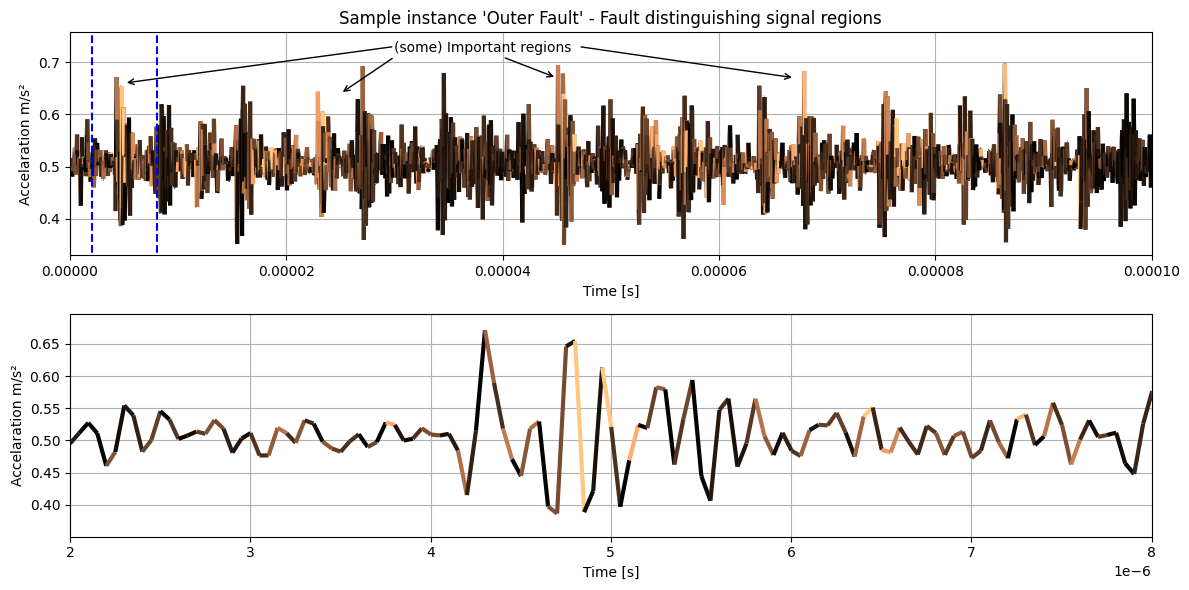

In [260]:
x = np.linspace(0, 1/FS, 2000)

fig, axes = plt.subplots(figsize=(12,6))

plt.subplot(211)
ig.colorline(x, x_ig, value, norm=plt.Normalize(0.0, 5.0e-9))
plt.xlim(x.min(), x.max())
plt.ylim(x_ig.min()-0.02, x_ig.max()+0.06)
plt.grid()
plt.title('Sample instance \'Outer Fault\' - Fault distinguishing signal regions')
plt.ylabel('Accelaration m/s²')
plt.xlabel('Time [s]')
      

   
plt.text(3e-5, 0.72, '(some) Important regions')
plt.annotate("", xy=(5e-6, 0.66), xytext=(3e-5, 0.73), arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(2.5e-5, 0.64), xytext=(3e-5, 0.71), arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(4.5e-5, 0.67), xytext=(4e-5, 0.71), arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(6.7e-5, 0.67), xytext=(4.7e-5, 0.73), arrowprops=dict(arrowstyle="->"))
plt.plot([2e-6, 2e-6], [0.25, 0.8], 'bx--')
plt.plot([8e-6, 8e-6], [0.25, 0.8], 'bx--')


plt.subplot(212)
ig.colorline(x, x_ig, value, norm=plt.Normalize(0.0, 6.0e-9))
plt.xlim(2e-6, 8e-6)
plt.ylim(x_ig.min(), x_ig.max())
plt.grid()
plt.ylabel('Accelaration m/s²')
plt.xlabel('Time [s]')

plt.tight_layout()
plt.savefig('Important_Regions_Explained.pdf', dpi=600)
plt.show()

